In [1]:
!pip install larq
!pip install keras-tuner

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print("TensorFlow version:", tf.__version__)
import larq as lq
import keras
from sklearn.model_selection import train_test_split

TensorFlow version: 2.7.0


# Toy-dataset

In [63]:
num_images_left_under = 50000
num_images_right_above = 50000

dataset_left_under = np.empty((num_images_left_under, 2, 2), dtype=np.uint8)
dataset_right_above = np.empty((num_images_right_above, 2, 2), dtype=np.uint8)

for i in range(num_images_left_under):
    image = np.zeros((2, 2), dtype=np.uint8)
    image[0, 0] = np.random.randint(0, 255) #255 not included
    image[0, 1] = np.random.randint(0, 255)
    image[1, 1] = np.random.randint(0, 255)
    image[1, 0] = 255
    dataset_left_under[i] = image
    
for i in range(num_images_right_above):
    image = np.zeros((2, 2), dtype=np.uint8)
    image[0, 0] = np.random.randint(0, 255)
    image[1, 0] = np.random.randint(0, 255)
    image[1, 1] = np.random.randint(0, 255)
    image[0, 1] = 255
    dataset_right_above[i] = image    

y_left_under = np.full(num_images_left_under, 1)
y_right_above = np.full(num_images_right_above, 0) 


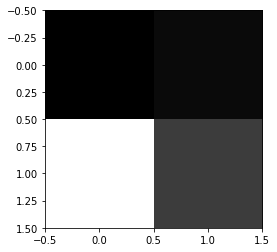

In [64]:
fig = plt.figure
plt.imshow(dataset_left_under[10], cmap='gray')
plt.show()

In [65]:
x_dataset = np.concatenate((dataset_left_under, dataset_right_above))
y_dataset = np.concatenate((y_left_under, y_right_above))

x_train, x_test, y_train, y_test = train_test_split(
    x_dataset, y_dataset, test_size=0.2, random_state=42)

In [66]:
x_train, x_test = x_train.reshape(80000, 4).astype("float32") / 127.5 - 1, x_test.reshape(20000, 4).astype("float32") / 127.5 - 1

In [67]:
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_train = tf.keras.utils.to_categorical(y_train, 2)

# MNIST dataset resize to 2x2

In [83]:
mnist = tf.keras.datasets.mnist # Dataset consistent of 28x28 images of the handwritten numbers 0 to 9


(x_train, y_train), (x_test, y_test) = mnist.load_data() 

print(x_train.shape) 
#print(x_train)
train_0_1 = np.where((y_train == 0 ) | (y_train == 1))
test_0_1 = np.where((y_test == 0) | (y_test == 1))
x_train, y_train = x_train[train_0_1], y_train[train_0_1]
x_test, y_test = x_test[test_0_1], y_test[test_0_1]
print(len(x_train))
print(len(x_test))

(60000, 28, 28)
12665
2115


In [84]:
#resize
x_train = np.expand_dims(x_train, axis=-1) #extra dimension for resizing
x_train = tf.image.resize(x_train, [2,2]) 
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [2,2]) 

In [85]:
#remove extra dimension
x_train = x_train[:, :, :, 0] 
x_test = x_test[:, :, :, 0]

In [86]:
#from tensorflow to numpy array
x_train = x_train.numpy()
x_test = x_test.numpy()

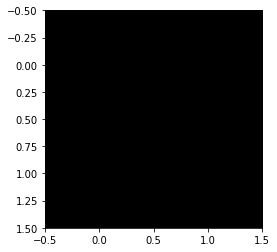

In [87]:
fig = plt.figure
plt.imshow(x_train[10], cmap='gray')
plt.show()

In [88]:
x_train, x_test = x_train.reshape(12665, 4).astype("float32") / 127.5 - 1, x_test.reshape(2115, 4).astype("float32") / 127.5 - 1

In [89]:
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_train = tf.keras.utils.to_categorical(y_train, 2)

# binary neural network

In [8]:
# !! don't use this one

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

# In the first layer we only quantize the weights and not the input
model.add(tf.keras.layers.Flatten(input_shape=(2, 2)))



model.add(lq.layers.QuantDense(2,
                                activation='relu',
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(2, 2)))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantDense(2, activation='softmax', use_bias=False, **kwargs))


In [90]:
# !! use this one
def create_model():
    kwargs = dict(input_quantizer="ste_sign",
                  kernel_quantizer="ste_sign",
                  kernel_constraint="weight_clip")

    model = tf.keras.models.Sequential()

    # In the first layer we only quantize the weights and not the input
    #model.add(tf.keras.layers.Flatten(input_shape=(2, 2)))


    model.add(lq.layers.QuantDense(6,
                                    kernel_quantizer="ste_sign",
                                    kernel_constraint="weight_clip",
                                    use_bias=False))

    model.add(lq.layers.QuantDense(2,
                                    input_quantizer="ste_sign",
                                    kernel_quantizer="ste_sign",
                                    kernel_constraint="weight_clip",
                                    use_bias=False))
    #model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    #model.add(tf.keras.layers.BatchNormalization(scale=False))

    #model.add(lq.layers.QuantDense(2, activation='softmax', use_bias=False, **kwargs))
    model.add(tf.keras.layers.Activation("softmax"))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])
    
    return model

In [91]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
#             metrics=['accuracy'])

accu = []

for i in range(10):
    model = create_model()
    # When the next line is executed, the training of the model is done.
    # Epochs stands for the number of cycles the ANN trains for, with the entire training dataset. 
    #history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)
    model.fit(x_train, y_train, epochs=50, batch_size=75, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    accu.append(test_acc)

67/67 [==============================] - 0s 741us/step - loss: 0.6837 - accuracy: 0.4449


In [62]:
test_loss, test_acc = model.evaluate(x_test, y_test)

625/625 [==============================] - 1s 796us/step - loss: 0.4927 - accuracy: 0.8331


In [354]:
model.save("full_precision_model.h5")  # save full precision latent weights
fp_weights = model.get_weights()  # get latent weights
print(fp_weights)
with lq.context.quantized_scope(True):
    model.save("binary_model.h5")  # save binary weights
    weights = model.get_weights()  # get binary weights
    print(weights)

[array([[ 1.00000000e+00,  7.96708763e-01,  2.17636526e-01,
        -1.82388812e-01,  8.26059058e-02,  8.94632578e-01],
       [ 1.33934757e-03, -7.07818493e-02,  2.19957098e-01,
         3.27603018e-04, -6.58553600e-01, -2.28876635e-01],
       [-3.02159823e-02, -3.54662712e-04, -4.03533041e-01,
         6.17746592e-01, -7.28839457e-01,  9.22197938e-01],
       [ 6.05950714e-04, -1.08276166e-01,  9.81539270e-05,
         8.09327245e-01,  2.79122778e-05, -2.84339249e-01]], dtype=float32), array([[-1.3782805e-02, -3.7056890e-03],
       [-7.5385942e-05,  9.7954434e-01],
       [-7.7918380e-01,  1.7418148e-04],
       [ 1.0257229e-04, -3.5972688e-01],
       [-5.5621982e-05,  2.9301235e-01],
       [-4.7416243e-01, -5.2719682e-01]], dtype=float32)]
[array([[ 1.,  1.,  1., -1.,  1.,  1.],
       [ 1., -1.,  1.,  1., -1., -1.],
       [-1., -1., -1.,  1., -1.,  1.],
       [ 1., -1.,  1.,  1.,  1., -1.]], dtype=float32), array([[-1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1.,

In [92]:
data = [0.7277, 0.7277, 0.8217]  # Replace with your data

mean = np.mean(accu)
std = np.std(accu)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 0.6336170256137847
Standard Deviation: 0.1679508866279757
